# Assignment 4

In [ ]:
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from torch import optim, cuda
import torch
import torch.nn as nn
import os
from PIL import Image
import warnings
from time import time
warnings.filterwarnings('ignore', category = FutureWarning)
from torch.utils.tensorboard import SummaryWriter

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
traindir = '/content/drive/MyDrive/train/'
testdir = '/content/drive/MyDrive/test/'

# Data Pre-Processing

In [ ]:
categories = []
img_categories = []
n_train = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

In [ ]:
# Dataframe of categories
num_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                        'n_test': n_test}).\
    sort_values('category')
print(num_df)

  category  n_train  n_test
0     ants       80      20
1     dogs       80      20


In [ ]:
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})
print(image_df)

    category  height  width
0       ants     496    790
1       ants    2900   4350
2       ants     800   1200
3       ants    1675   3200
4       ants    2800   4200
..       ...     ...    ...
155     dogs     600   1200
156     dogs    1600   2400
157     dogs     690    960
158     dogs     450    845
159     dogs     600   1200

[160 rows x 3 columns]


In [ ]:
# Function to display a tensor image
def imshow_tensor(tensor, title=None):

    unnormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )

    image_tensor = unnormalize(tensor)
    image = image_tensor.numpy().transpose((1, 2, 0))
    image = image.clip(0, 1)


    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [ ]:
# Simple transformation for models without augmentation
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Augmented transformation for models with augmentation
image_aug_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"Simple transformation: {simple_transform}")
print(f"Augmented transformation: {image_aug_transforms}")


Simple transformation: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Augmented transformation: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [ ]:
traindir = '/content/drive/MyDrive/train/'
testdir = '/content/drive/MyDrive/test/'

images = {
    'train': datasets.ImageFolder(root=traindir, transform=simple_transform),
    'test': datasets.ImageFolder(root=testdir, transform=simple_transform)
}

images_aug = {
    'train': datasets.ImageFolder(root=traindir, transform=image_aug_transforms),
    'test': datasets.ImageFolder(root=testdir, transform=simple_transform)
}

In [ ]:
batch_size = 8

dataloaders = {
    'train': DataLoader(torch.utils.data.Subset(images['train'], range(0, 140)), batch_size=batch_size, shuffle=True),
    'val' : DataLoader(torch.utils.data.Subset(images['train'], range(140, 160)), batch_size=batch_size, shuffle=True),
    'test': DataLoader(images['test'], batch_size=batch_size, shuffle=True)
}

aug_dataloaders = {
    'train': DataLoader(torch.utils.data.Subset(images_aug['train'], range(0, 140)), batch_size=batch_size, shuffle=True),
    'val' : DataLoader(torch.utils.data.Subset(images_aug['train'], range(140, 160)), batch_size=batch_size, shuffle=True),
    'test': DataLoader(images_aug['test'], batch_size=batch_size, shuffle=True)
}

print(f"Number of training images: {len(images['train'])}")
print(f"Number of testing images: {len(images['test'])}")
print(f"Number of classes: {len(images['train'].classes)}")
print(f"Batch size: {batch_size}")

Number of training images: 160
Number of testing images: 40
Number of classes: 2
Batch size: 8


Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8])
Batch labels: tensor([1, 0, 0, 1, 0, 0, 0, 0])


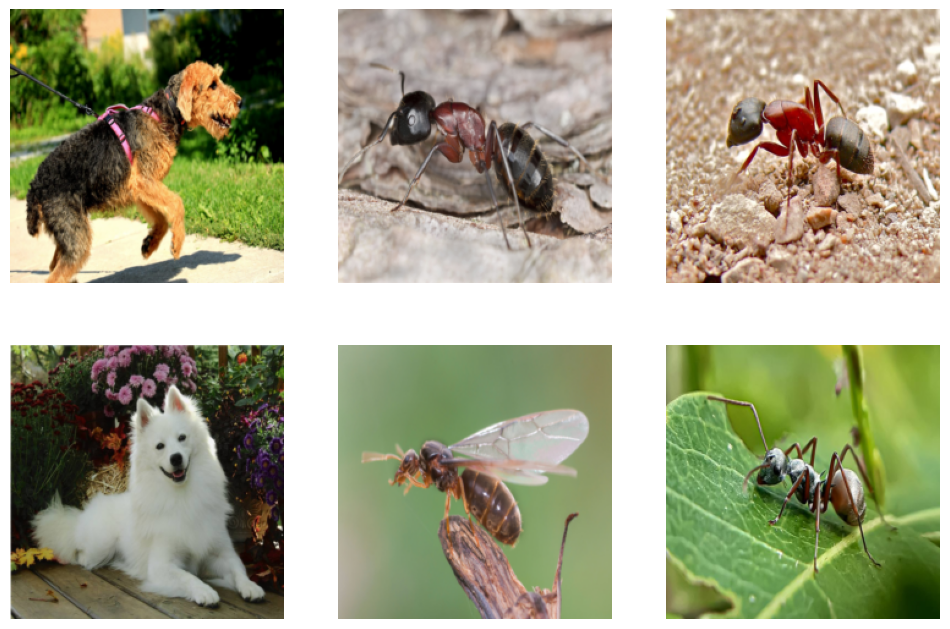

In [ ]:
train_data_iter = iter(dataloaders['train'])
images_batch, labels = next(train_data_iter)

print(f"Image batch shape: {images_batch.shape}")
print(f"Label batch shape: {labels.shape}")
print(f"Batch labels: {labels}")

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    imshow_tensor(images_batch[i])
    plt.axis('off')

Augmented image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8])
Batch labels (augmented): tensor([1, 1, 0, 0, 1, 0, 0, 0])


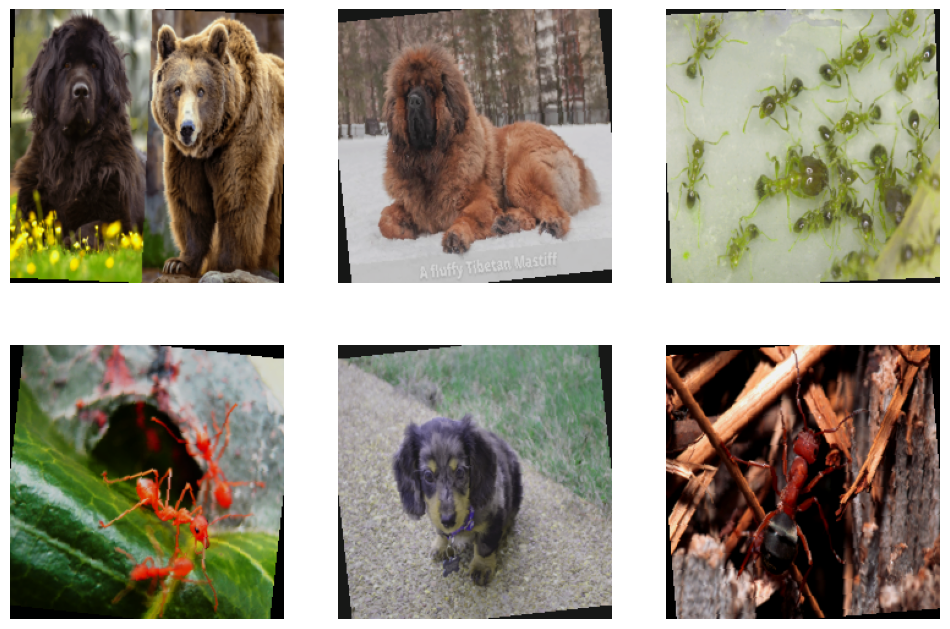

In [ ]:
# Augmented data visualization
train_data_iter_aug = iter(aug_dataloaders['train'])
images_aug, labels_aug = next(train_data_iter_aug)

print(f"Augmented image batch shape: {images_aug.shape}")
print(f"Label batch shape: {labels_aug.shape}")
print(f"Batch labels (augmented): {labels_aug}")

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    imshow_tensor(images_aug[i])
    plt.axis('off')

In [ ]:
category_count = pd.DataFrame({
    'Category': [category for category, _ in images['train'].class_to_idx.items()],
    'Number of images': [len(os.listdir(os.path.join(traindir, category))) for category in images['train'].class_to_idx]
})

print("Class distribution:")
print(category_count)

image_sizes = [(img.shape[1], img.shape[2]) for img, _ in dataloaders['train'].dataset]
size_df = pd.DataFrame(image_sizes, columns=['Height', 'Width'])

print("Image size statistics:")
print(size_df.describe())


Class distribution:
  Category  Number of images
0     ants                80
1     dogs                80
Image size statistics:
       Height  Width
count   140.0  140.0
mean    224.0  224.0
std       0.0    0.0
min     224.0  224.0
25%     224.0  224.0
50%     224.0  224.0
75%     224.0  224.0
max     224.0  224.0


In [ ]:
n_classes = len(num_df)
print(f'There are {n_classes} different classes.')

len(images['train'].classes)

There are 2 different classes.


2

In [ ]:
for image , label in dataloaders['train']:
    print(image.shape)
    print(label)
    print(label.shape)
    break

torch.Size([8, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 1, 0, 0])
torch.Size([8])


# VGG 1 Block

In [ ]:
def define_model():
    model = nn.Sequential(
      nn.Conv2d(3, 32, 3),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Flatten(),
      nn.Linear(32*111*111 , 128),
      nn.ReLU(),
      nn.Linear(128, 2)
      )
    return model

In [ ]:
vgg1 = define_model()
if DEVICE == 'cuda':
  vgg1.to('cuda')

In [ ]:
summary(vgg1, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
              ReLU-2         [-1, 32, 222, 222]               0
         MaxPool2d-3         [-1, 32, 111, 111]               0
           Flatten-4               [-1, 394272]               0
            Linear-5                  [-1, 128]      50,466,944
              ReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 2]             258
Total params: 50,468,098
Trainable params: 50,468,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 30.08
Params size (MB): 192.52
Estimated Total Size (MB): 223.18
----------------------------------------------------------------


In [ ]:
vgg1.class_to_idx =  images['train'].class_to_idx
vgg1.idx_to_class = {
    idx: class_
    for class_, idx in vgg1.class_to_idx.items()
}

list(vgg1.idx_to_class.items())[:10]

[(0, 'ants'), (1, 'dogs')]

In [ ]:
total_params_vgg = sum(p.numel() for p in vgg1.parameters())
total_params_vgg

50468098

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg1.parameters())
n_epochs = 10

train_losses = []
val_losses = []
train_accuracy = []
valid_accuracy = []
training_time = []

writer = SummaryWriter(f'runs/vgg1/')
step = 0
overall_start_time = time()
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0
    valid_acc = 0

    vgg1.train()
    start_time = time()
    for data, target in dataloaders['train']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = vgg1(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        train_acc += acc.item() * data.size(0)

        writer.add_scalar('Trainig Loss/ Iteration', loss, global_step = step)
        writer.add_scalar('Training Accuracy / Iteration', acc, global_step = step)

        step += 1

    train_time = time() - start_time
    print(f'Training time in {epoch+1} is {train_time}\n')

    # Evaluate the model
    vgg1.eval()
    for data, target in dataloaders['val']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        output = vgg1(data)
        loss = criterion(output, target)
        val_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        valid_acc += acc.item() * data.size(0)



    train_loss = train_loss/len(dataloaders['train'].sampler)
    val_loss = val_loss/len(dataloaders['val'].sampler)
    train_acc = train_acc / len(dataloaders['train'].sampler)
    valid_acc = valid_acc / len(dataloaders['val'].sampler)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    training_time.append(train_time)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        val_loss
        ))


overall_train_time = time() - overall_start_time
print(f'Overall time taken for {epoch} including training and validation {overall_train_time}')

In [ ]:
vgg1_acc_loss_time = pd.DataFrame([], columns = ['TrainingLoss','ValidationLoss', 'TrainingTime', 'TrainingAccuracy','ValidAccuracy', 'TestAccuracy','TotalParameters'  ])
vgg1_acc_loss_time = pd.DataFrame({'TrainingLoss' : train_losses,
                              'ValidationLoss' : val_losses,
                              'TrainingTime' : training_time,
                              'TrainingAccuracy' : train_accuracy,
                              'ValidAccuracy' : valid_accuracy,
                              'TotalParameters': total_params_vgg
                              })
vgg1_acc_loss_time

In [ ]:
fig , ax =plt.subplots(nrows=1,ncols =2, figsize = (15,5))
ax[0].plot( range(10), vgg1_acc_loss_time['TrainingLoss'], label= 'Training Loss')
ax[0].plot( range(10), vgg1_acc_loss_time['ValidationLoss'], label= 'Validation Loss')
ax[1].plot( range(10), vgg1_acc_loss_time['TrainingAccuracy'], label= 'Training Accuracy')
ax[1].plot( range(10), vgg1_acc_loss_time['ValidAccuracy'], label= 'Validation Accuracy')
ax[0].legend()
ax[1].legend()

In [ ]:
test_acc = 0
step = 0

test_images = []
test_labels = []
predictions = []

for input, target in dataloaders['test']:
    if DEVICE == 'cuda':
        input, target = input.cuda(), target.cuda()

    output = vgg1(input)
    pred = torch.argmax(input=output, dim=1)

    correct_labels = pred.eq(target.data.view_as(pred))
    acc = torch.mean(correct_labels.type(torch.FloatTensor))
    test_acc += acc.item() * input.size(0)

    test_images.append(input.cpu())
    test_labels.append(target.cpu())
    predictions.append(pred.cpu())

    img = input[0].cpu().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f'Predicted: {vgg1.idx_to_class[pred[0].item()]}')
    ax.set_axis_off()

    writer.add_scalar('Testing Accuracy / Iteration', acc, global_step=step)
    writer.add_figure('Test images & Label', fig, global_step=step)



    step += 1

test_acc = test_acc / len(dataloaders['test'].sampler)
vgg1_acc_loss_time['TestAccuracy'] = np.repeat(test_acc, len(vgg1_acc_loss_time))

print(f'Testing accuracy is {test_acc}')

test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)
predictions = torch.cat(predictions, dim=0)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < test_images.size(0):
        img = test_images[i].squeeze().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Pred: {vgg1.idx_to_class[predictions[i].item()]}', fontsize=10)
        ax.set_axis_off()

plt.tight_layout()
writer.add_figure('All Test Images & Predictions', fig)
plt.show()

In [ ]:
%reload_ext tensorboard


In [ ]:
%tensorboard --logdir runs/vgg1

#VGG 3


In [ ]:
def define_model():
  model = nn.Sequential(
      nn.Conv2d(3, 32, 3), # 3 input channel, 32 filters of size 3x3
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(32, 64, 3),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(64, 128, 3),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Flatten(),
      nn.Linear(26 * 26 *128 , 128),
      nn.ReLU(),
      nn.Linear(128, 2)
  )
  return model

In [ ]:
vgg3 = define_model()

In [ ]:
if DEVICE == 'cuda':
  vgg3.to('cuda')

In [ ]:
summary(vgg3, input_size = (3, 224, 224))

In [ ]:
vgg3.class_to_idx =  images['train'].class_to_idx
vgg3.idx_to_class = {
    idx: class_
    for class_, idx in vgg3.class_to_idx.items()
}

list(vgg3.idx_to_class.items())[:10]

In [ ]:
total_params = sum(p.numel() for p in vgg3.parameters())
total_params

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg3.parameters())

n_epochs = 10

train_losses = []
val_losses = []
train_accuracy = []
valid_accuracy = []
training_time = []

writer = SummaryWriter(f'runs/vgg3/')
step = 0
overall_start_time = time()
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0
    valid_acc = 0

    # Train the model
    vgg3.train()
    start_time = time()
    for data, target in dataloaders['train']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = vgg3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        train_acc += acc.item() * data.size(0)

        writer.add_scalar('Trainig Loss/ Iteration', loss, global_step = step)
        writer.add_scalar('Training Accuracy / Iteration', acc, global_step = step)

        step += 1

    train_time = time() - start_time
    print(f'Training time in {epoch+1} is {train_time}\n')

    # Evaluate the model
    vgg3.eval()
    for data, target in dataloaders['val']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        output = vgg3(data)
        loss = criterion(output, target)
        val_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        valid_acc += acc.item() * data.size(0)



    train_loss = train_loss/len(dataloaders['train'].sampler)
    val_loss = val_loss/len(dataloaders['val'].sampler)
    train_acc = train_acc / len(dataloaders['train'].sampler)
    valid_acc = valid_acc / len(dataloaders['val'].sampler)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    training_time.append(train_time)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        val_loss
        ))


overall_train_time = time() - overall_start_time
print(f'Overall time taken for {epoch} including training and validation {overall_train_time}')

In [ ]:
vgg3_acc_loss_time = pd.DataFrame([], columns = ['TrainingLoss','ValidationLoss', 'TrainingTime', 'TrainingAccuracy','ValidAccuracy', 'TestAccuracy','TotalParameters'  ])
vgg3_acc_loss_time = pd.DataFrame({'TrainingLoss' : train_losses,
                              'ValidationLoss' : val_losses,
                              'TrainingTime' : training_time,
                              'TrainingAccuracy' : train_accuracy,
                              'ValidAccuracy' : valid_accuracy,
                              'TotalParameters': total_params
                              })
vgg3_acc_loss_time

In [ ]:
fig , ax =plt.subplots(nrows=1,ncols =2, figsize = (15,5))
ax[0].plot( range(10), vgg3_acc_loss_time['TrainingLoss'], label= 'Training Loss')
ax[0].plot( range(10), vgg3_acc_loss_time['ValidationLoss'], label= 'Validation Loss')
ax[1].plot( range(10), vgg3_acc_loss_time['TrainingAccuracy'], label= 'Training Accuracy')
ax[1].plot( range(10), vgg3_acc_loss_time['ValidAccuracy'], label= 'Validation Accuracy')
ax[0].legend()
ax[1].legend()

In [ ]:
test_acc = 0
step = 0

test_images = []
test_labels = []
predictions = []

for input, target in dataloaders['test']:
    if DEVICE == 'cuda':
        input, target = input.cuda(), target.cuda()

    output = vgg3(input)
    pred = torch.argmax(input=output, dim=1)

    correct_labels = pred.eq(target.data.view_as(pred))
    acc = torch.mean(correct_labels.type(torch.FloatTensor))
    test_acc += acc.item() * input.size(0)

    test_images.append(input.cpu())
    test_labels.append(target.cpu())
    predictions.append(pred.cpu())

    img = input[0].cpu().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f'Predicted: {vgg3.idx_to_class[pred[0].item()]}')
    ax.set_axis_off()

    writer.add_scalar('Testing Accuracy / Iteration', acc, global_step=step)
    writer.add_figure('Test images & Label', fig, global_step=step)

    step += 1

test_acc = test_acc / len(dataloaders['test'].sampler)
vgg3_acc_loss_time['TestAccuracy'] = np.repeat(test_acc, len(vgg3_acc_loss_time))

print(f'Testing accuracy is {test_acc}')

test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)
predictions = torch.cat(predictions, dim=0)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < test_images.size(0):
        img = test_images[i].squeeze().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Pred: {vgg3.idx_to_class[predictions[i].item()]}', fontsize=10)
        ax.set_axis_off()

plt.tight_layout()
writer.add_figure('All Test Images & Predictions', fig)
plt.show()

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir runs/vgg3

#VGG 3 Augmented

In [ ]:
vgg3_aug = define_model()

In [ ]:
total_params = sum(p.numel() for p in vgg3_aug.parameters())
total_params

In [ ]:
if DEVICE == 'cuda':
  vgg3_aug.to('cuda')

In [ ]:
class_to_idx = aug_dataloaders['train'].dataset.dataset.class_to_idx
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg3_aug.parameters())
n_epochs = 10

train_losses = []
val_losses = []
train_accuracy = []
valid_accuracy = []
training_time = []

writer1 = SummaryWriter(f'runs/vgg3_aug/')
step = 0
overall_start_time = time()
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0
    valid_acc = 0

    # Train the model
    vgg3_aug.train()
    start_time = time()
    for data, target in aug_dataloaders['train']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = vgg3_aug(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        train_acc += acc.item() * data.size(0)

        writer1.add_scalar('Trainig Loss/ Iteration', loss, global_step = step)
        writer1.add_scalar('Training Accuracy / Iteration', acc, global_step = step)
        step += 1

    train_time = time() - start_time
    print(f'Training time in {epoch+1} is {train_time}\n')

    # Evaluate the model
    vgg3_aug.eval()
    for data, target in aug_dataloaders['val']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        output = vgg3_aug(data)
        loss = criterion(output, target)
        val_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        valid_acc += acc.item() * data.size(0)



    train_loss = train_loss/len(aug_dataloaders['train'].sampler)
    val_loss = val_loss/len(aug_dataloaders['val'].sampler)
    train_acc = train_acc / len(aug_dataloaders['train'].sampler)
    valid_acc = valid_acc / len(aug_dataloaders['val'].sampler)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    training_time.append(train_time)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        val_loss
        ))


overall_train_time = time() - overall_start_time
print(f'Overall time taken for {epoch} including training and validation {overall_train_time}')

In [ ]:
vgg3_aug_acc_loss_time = pd.DataFrame([], columns = ['TrainingLoss', 'ValidationLoss', 'TrainingTime', 'TrainingAccuracy','ValidAccuracy', 'TestAccuracy', 'TotalParameters'  ])
vgg3_aug_acc_loss_time = pd.DataFrame({'TrainingLoss' : train_losses,
                              'ValidationLoss' : val_losses,
                              'TrainingTime' : training_time,
                              'TrainingAccuracy' : train_accuracy,
                              'ValidAccuracy' : valid_accuracy,
                              'TotalParameters': total_params
                              })
vgg3_aug_acc_loss_time

In [ ]:
fig , ax =plt.subplots(nrows=1,ncols =2, figsize = (15,5))
ax[0].plot( range(10), vgg3_aug_acc_loss_time['TrainingLoss'], label= 'Training Loss')
ax[0].plot( range(10), vgg3_aug_acc_loss_time['ValidationLoss'], label= 'Validation Loss')
ax[1].plot( range(10), vgg3_aug_acc_loss_time['TrainingAccuracy'], label= 'Training Accuracy')
ax[1].plot( range(10), vgg3_aug_acc_loss_time['ValidAccuracy'], label= 'Validation Accuracy')
ax[0].legend()
ax[1].legend()

In [ ]:
test_acc = 0
step = 0

test_images = []
test_labels = []
predictions = []

for input, target in aug_dataloaders['test']:
    if DEVICE == 'cuda':
        input, target = input.cuda(), target.cuda()

    output = vgg3_aug(input)
    pred = torch.argmax(input=output, dim=1)

    correct_labels = pred.eq(target.data.view_as(pred))
    acc = torch.mean(correct_labels.type(torch.FloatTensor))
    test_acc += acc.item() * input.size(0)

    test_images.append(input.cpu())
    test_labels.append(target.cpu())
    predictions.append(pred.cpu())

    img = input[0].cpu().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f'Predicted: {idx_to_class[pred[0].item()]}')
    ax.set_axis_off()

    writer1.add_scalar('Testing Accuracy / Iteration', acc, global_step=step)
    writer1.add_figure('Test images & Label', fig, global_step=step)

    step += 1

test_acc = test_acc / len(aug_dataloaders['test'].sampler)
vgg3_aug_acc_loss_time['TestAccuracy'] = np.repeat(test_acc, len(vgg3_aug_acc_loss_time))

print(f'Testing accuracy is {test_acc}')

test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)
predictions = torch.cat(predictions, dim=0)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < test_images.size(0):
        img = test_images[i].squeeze().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Pred: {idx_to_class[predictions[i].item()]}', fontsize=10)
        ax.set_axis_off()

plt.tight_layout()
writer1.add_figure('All Test Images & Predictions', fig)
plt.show()

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir runs/vgg3_aug

# VGG 16 (Fully connected layer)

In [ ]:
vgg16 = models.vgg16(pretrained=True)

In [ ]:
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 2)
for params in vgg16.parameters():
  params.requires_grad = False

for params in vgg16.classifier.parameters():
  params.requires_grad = True

In [ ]:
if DEVICE == 'cuda':
  vgg16.to('cuda')

In [ ]:
summary(vgg16, input_size = (3, 224, 224))

In [ ]:
vgg16.class_to_idx =  images['train'].class_to_idx
vgg16.idx_to_class = {
    idx: class_
    for class_, idx in vgg16.class_to_idx.items()
}

list(vgg16.idx_to_class.items())[:10]

In [ ]:
total_params = sum(p.numel() for p in vgg16.parameters())
total_params

In [ ]:
total_parameters = sum(params.numel() for params in vgg16.parameters())
print(f'Total Parameters {total_parameters}')

trainable_parameters = sum(params.numel() for params in vgg16.parameters() if params.requires_grad)
print(f'Trainable Parameters {trainable_parameters}')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters())
n_epochs = 10

train_losses = []
val_losses = []
train_accuracy = []
valid_accuracy = []
training_time = []

writer = SummaryWriter(f'runs/vgg16/')
step = 0
overall_start_time = time()
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0
    valid_acc = 0

    # Train the model
    vgg16.train()
    start_time = time()
    for data, target in dataloaders['train']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = vgg16(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        train_acc += acc.item() * data.size(0)

        writer.add_scalar('Trainig Loss/ Iteration', loss, global_step = step)
        writer.add_scalar('Training Accuracy / Iteration', acc, global_step = step)

        step += 1

    train_time = time() - start_time
    print(f'Training time in {epoch+1} is {train_time}\n')

    # Evaluate the model
    vgg16.eval()
    for data, target in dataloaders['val']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        output = vgg16(data)
        loss = criterion(output, target)
        val_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        valid_acc += acc.item() * data.size(0)



    # Calculate average losses
    train_loss = train_loss/len(dataloaders['train'].sampler)
    val_loss = val_loss/len(dataloaders['val'].sampler)
    train_acc = train_acc / len(dataloaders['train'].sampler)
    valid_acc = valid_acc / len(dataloaders['val'].sampler)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    training_time.append(train_time)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        val_loss
        ))


overall_train_time = time() - overall_start_time
print(f'Overall time taken for {epoch} including training and validation {overall_train_time}')

In [ ]:
vgg16_acc_loss_time = pd.DataFrame([], columns = ['TrainingLoss','ValidationLoss', 'TrainingTime', 'TrainingAccuracy','ValidAccuracy', 'TestAccuracy','TotalParameters'  ])
vgg16_acc_loss_time = pd.DataFrame({'TrainingLoss' : train_losses,
                              'ValidationLoss' : val_losses,
                              'TrainingTime' : training_time,
                              'TrainingAccuracy' : train_accuracy,
                              'ValidAccuracy' : valid_accuracy,
                                    'TotalParameters': total_params
                              })
vgg16_acc_loss_time

In [ ]:
fig , ax =plt.subplots(nrows=1,ncols =2, figsize = (15,5))
ax[0].plot( range(10), vgg16_acc_loss_time['TrainingLoss'], label= 'Training Loss')
ax[0].plot( range(10), vgg16_acc_loss_time['ValidationLoss'], label= 'Validation Loss')
ax[1].plot( range(10), vgg16_acc_loss_time['TrainingAccuracy'], label= 'Training Accuracy')
ax[1].plot( range(10), vgg16_acc_loss_time['ValidAccuracy'], label= 'Validation Accuracy')
ax[0].legend()
ax[1].legend()

In [ ]:
test_acc = 0
step = 0

test_images = []
test_labels = []
predictions = []

for input, target in dataloaders['test']:
    if DEVICE == 'cuda':
        input, target = input.cuda(), target.cuda()

    output = vgg16(input)
    pred = torch.argmax(input=output, dim=1)

    correct_labels = pred.eq(target.data.view_as(pred))
    acc = torch.mean(correct_labels.type(torch.FloatTensor))
    test_acc += acc.item() * input.size(0)

    test_images.append(input.cpu())
    test_labels.append(target.cpu())
    predictions.append(pred.cpu())

    img = input[0].cpu().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f'Predicted: {vgg16.idx_to_class[pred[0].item()]}')
    ax.set_axis_off()

    writer.add_scalar('Testing Accuracy / Iteration', acc, global_step=step)
    writer.add_figure('Test images & Label', fig, global_step=step)

    step += 1

test_acc = test_acc / len(dataloaders['test'].sampler)
vgg16_acc_loss_time['TestAccuracy'] = np.repeat(test_acc, len(vgg16_acc_loss_time))

print(f'Testing accuracy is {test_acc}')

test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)
predictions = torch.cat(predictions, dim=0)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < test_images.size(0):
        img = test_images[i].squeeze().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Pred: {vgg16.idx_to_class[predictions[i].item()]}', fontsize=10)
        ax.set_axis_off()

plt.tight_layout()
writer.add_figure('All Test Images & Predictions', fig)
plt.show()

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir runs/vgg16

# VGG16 (Fine Tuning)

In [ ]:
vgg16_ft = models.vgg16(pretrained=True)

In [ ]:
vgg16_ft.classifier[6] = nn.Linear(vgg16_ft.classifier[6].in_features, 2)


In [ ]:
if DEVICE == 'cuda':
  vgg16_ft.to('cuda')

In [ ]:
vgg16_ft.class_to_idx =  images['train'].class_to_idx
vgg16_ft.idx_to_class = {
    idx: class_
    for class_, idx in vgg16_ft.class_to_idx.items()
}

list(vgg16_ft.idx_to_class.items())[:10]

In [ ]:
summary(vgg16_ft, input_size = (3, 224, 224))

In [ ]:
total_params = sum(p.numel() for p in vgg16_ft.parameters())
total_params

In [ ]:
total_parameters = sum(params.numel() for params in vgg16_ft.parameters())
print(f'Total Parameters {total_parameters}')

trainable_parameters = sum(params.numel() for params in vgg16_ft.parameters() if params.requires_grad)
print(f'Trainable Parameters {trainable_parameters}')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_ft.parameters())
n_epochs = 10

train_losses = []
val_losses = []
train_accuracy = []
valid_accuracy = []
training_time = []

writer = SummaryWriter(f'runs/vgg16_ft/')
step = 0
overall_start_time = time()
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0
    valid_acc = 0

    # Train the model
    vgg16_ft.train()
    start_time = time()
    for data, target in dataloaders['train']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = vgg16_ft(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        train_acc += acc.item() * data.size(0)

        writer.add_scalar('Trainig Loss/ Iteration', loss, global_step = step)
        writer.add_scalar('Training Accuracy / Iteration', acc, global_step = step)

        step += 1

    train_time = time() - start_time
    print(f'Training time in {epoch+1} is {train_time}\n')

    # Evaluate the model
    vgg16_ft.eval()
    for data, target in dataloaders['val']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        output = vgg16_ft(data)
        loss = criterion(output, target)
        val_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        valid_acc += acc.item() * data.size(0)



    # Calculate average losses
    train_loss = train_loss/len(dataloaders['train'].sampler)
    val_loss = val_loss/len(dataloaders['val'].sampler)
    train_acc = train_acc / len(dataloaders['train'].sampler)
    valid_acc = valid_acc / len(dataloaders['val'].sampler)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    training_time.append(train_time)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        val_loss
        ))


overall_train_time = time() - overall_start_time
print(f'Overall time taken for {epoch} including training and validation {overall_train_time}')

In [ ]:
vgg16_ft_acc_loss_time = pd.DataFrame([], columns = ['TrainingLoss','ValidationLoss', 'TrainingTime', 'TrainingAccuracy','ValidAccuracy', 'TestAccuracy','TotalParameters'  ])
vgg16_ft_acc_loss_time = pd.DataFrame({'TrainingLoss' : train_losses,
                              'ValidationLoss' : val_losses,
                              'TrainingTime' : training_time,
                              'TrainingAccuracy' : train_accuracy,
                              'ValidAccuracy' : valid_accuracy,
                                       'TotalParameters': total_params
                              })
vgg16_ft_acc_loss_time

In [ ]:
fig , ax =plt.subplots(nrows=1,ncols =2, figsize = (15,5))
ax[0].plot( range(10), vgg16_ft_acc_loss_time['TrainingLoss'], label= 'Training Loss')
ax[0].plot( range(10), vgg16_ft_acc_loss_time['ValidationLoss'], label= 'Validation Loss')
ax[1].plot( range(10), vgg16_ft_acc_loss_time['TrainingAccuracy'], label= 'Training Accuracy')
ax[1].plot( range(10), vgg16_ft_acc_loss_time['ValidAccuracy'], label= 'Validation Accuracy')
ax[0].legend()
ax[1].legend()

In [ ]:
test_acc = 0
step = 0

test_images = []
test_labels = []
predictions = []

for input, target in dataloaders['test']:
    if DEVICE == 'cuda':
        input, target = input.cuda(), target.cuda()

    output = vgg16_ft(input)
    pred = torch.argmax(input=output, dim=1)

    correct_labels = pred.eq(target.data.view_as(pred))
    acc = torch.mean(correct_labels.type(torch.FloatTensor))
    test_acc += acc.item() * input.size(0)

    test_images.append(input.cpu())
    test_labels.append(target.cpu())
    predictions.append(pred.cpu())

    img = input[0].cpu().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f'Predicted: {vgg3.idx_to_class[pred[0].item()]}')
    ax.set_axis_off()

    writer.add_scalar('Testing Accuracy / Iteration', acc, global_step=step)
    writer.add_figure('Test images & Label', fig, global_step=step)

    step += 1

test_acc = test_acc / len(dataloaders['test'].sampler)
vgg16_ft_acc_loss_time['TestAccuracy'] = np.repeat(test_acc, len(vgg16_ft_acc_loss_time))

print(f'Testing accuracy is {test_acc}')

test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)
predictions = torch.cat(predictions, dim=0)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < test_images.size(0):
        img = test_images[i].squeeze().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Pred: {vgg16_ft.idx_to_class[predictions[i].item()]}', fontsize=10)
        ax.set_axis_off()

plt.tight_layout()
writer.add_figure('All Test Images & Predictions', fig)
plt.show()

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir runs/vgg16_ft

# Training MLP

In [ ]:
MLP = nn.Sequential(
    nn.Linear(150528, 900),
    nn.ReLU(),
    nn.Linear(900, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,2)
)
if DEVICE == 'cuda':
  MLP.to('cuda')

In [ ]:
MLP.class_to_idx =  images['train'].class_to_idx
MLP.idx_to_class = {
    idx: class_
    for class_, idx in images['train'].class_to_idx.items()
}

list(MLP.idx_to_class.items())[:10]

In [ ]:
summary(MLP, input_size = (150528,))

In [ ]:
total_params = sum(p.numel() for p in MLP.parameters())
total_params

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP.parameters())
n_epochs = 10

train_losses = []
val_losses = []
train_accuracy = []
valid_accuracy = []
training_time = []

writer = SummaryWriter(f'runs/MLP/')
step = 0
overall_start_time = time()
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0
    valid_acc = 0

    # Train the model
    MLP.train()
    start_time = time()
    for data, target in dataloaders['train']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = MLP(data.view(data.size(0), -1))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        train_acc += acc.item() * data.size(0)

        writer.add_scalar('Trainig Loss/ Iteration', loss, global_step = step)
        writer.add_scalar('Training Accuracy / Iteration', acc, global_step = step)

        step += 1

    train_time = time() - start_time
    print(f'Training time in {epoch+1} is {train_time}\n')

    # Evaluate the model
    MLP.eval()
    for data, target in dataloaders['val']:
        if DEVICE == 'cuda':
          data, target = data.cuda(), target.cuda()
          output = MLP(data.view(data.size(0), -1))
        loss = criterion(output, target)
        val_loss += loss.item()*data.size(0)

        pred = torch.argmax(input = output, dim = 1)
        correct_labels = pred.eq(target.data.view_as(pred))
        acc = torch.mean(correct_labels.type(torch.FloatTensor))
        valid_acc += acc.item() * data.size(0)



    # Calculate average losses
    train_loss = train_loss/len(dataloaders['train'].sampler)
    val_loss = val_loss/len(dataloaders['val'].sampler)
    train_acc = train_acc / len(dataloaders['train'].sampler)
    valid_acc = valid_acc / len(dataloaders['val'].sampler)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    training_time.append(train_time)

    # Print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        val_loss
        ))


overall_train_time = time() - overall_start_time
print(f'Overall time taken for {epoch} including training and validation {overall_train_time}')

In [ ]:
mlp_acc_loss_time = pd.DataFrame([], columns = ['TrainingLoss','ValidationLoss', 'TrainingTime', 'TrainingAccuracy','ValidAccuracy', 'TestAccuracy','TotalParameters'  ])
mlp_acc_loss_time = pd.DataFrame({'TrainingLoss' : train_losses,
                              'ValidationLoss' : val_losses,
                              'TrainingTime' : training_time,
                              'TrainingAccuracy' : train_accuracy,
                              'ValidAccuracy' : valid_accuracy,
                                  'TotalParameters':total_params
                              })
mlp_acc_loss_time

In [ ]:
fig , ax =plt.subplots(nrows=1,ncols =2, figsize = (15,5))
ax[0].plot( range(10), mlp_acc_loss_time['TrainingLoss'], label= 'Training Loss')
ax[0].plot( range(10), mlp_acc_loss_time['ValidationLoss'], label= 'Validation Loss')
ax[1].plot( range(10), mlp_acc_loss_time['TrainingAccuracy'], label= 'Training Accuracy')
ax[1].plot( range(10), mlp_acc_loss_time['ValidAccuracy'], label= 'Validation Accuracy')
ax[0].legend()
ax[1].legend()

In [ ]:
test_acc = 0
step = 0

test_images = []
test_labels = []
predictions = []

for input, target in dataloaders['test']:
    if DEVICE == 'cuda':
        input, target = input.cuda(), target.cuda()

    output = MLP(input.view(input.size(0), -1))
    pred = torch.argmax(input=output, dim=1)

    correct_labels = pred.eq(target.data.view_as(pred))
    acc = torch.mean(correct_labels.type(torch.FloatTensor))
    test_acc += acc.item() * input.size(0)

    test_images.append(input.cpu())
    test_labels.append(target.cpu())
    predictions.append(pred.cpu())

    img = input[0].cpu().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f'Predicted: {vgg3.idx_to_class[pred[0].item()]}')
    ax.set_axis_off()

    writer.add_scalar('Testing Accuracy / Iteration', acc, global_step=step)
    writer.add_figure('Test images & Label', fig, global_step=step)

    step += 1

test_acc = test_acc / len(dataloaders['test'].sampler)
mlp_acc_loss_time['TestAccuracy'] = np.repeat(test_acc, len(mlp_acc_loss_time))

print(f'Testing accuracy is {test_acc}')

test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)
predictions = torch.cat(predictions, dim=0)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < test_images.size(0):
        img = test_images[i].squeeze().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Pred: {MLP.idx_to_class[predictions[i].item()]}', fontsize=10)
        ax.set_axis_off()

plt.tight_layout()
writer.add_figure('All Test Images & Predictions', fig)
plt.show()

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir runs/MLP

# Results

In [ ]:
combined_table = pd.concat([vgg1_acc_loss_time.mean(),vgg3_acc_loss_time.mean(), vgg3_aug_acc_loss_time.mean(),vgg16_acc_loss_time.mean(),vgg16_ft_acc_loss_time.mean(),mlp_acc_loss_time.mean()], axis = 1).T
combined_table.index = ['VGG1','VGG3','VGG3_augmentation','VGG16_FC','VGG16_entire','MLP']
combined_table

# Theory

- Are the results as expected? Why or why not?

VGG1, being the simplest, shows lower accuracy compared to other models, which have more layers and can capture more complex features from the images
VGG3 and VGG3_aug should perform slightly better than VGG1 due to the increased depth and the effect of data augmentation. Data augmentation (such as random rotations, flips, or color changes) usually improves the generalization of the model by preventing overfitting on the training data, which may explain better performance

VGG16: This model is typically stronger in performance because it has many more layers, allowing it to capture finer details in images, as it has more parameters and can capture complex features. When fine-tuning the entire VGG16 model, the entire model adapts to the specific task of distinguishing between dogs and ants. Fine-tuning allows the model to better adjust the convolutional layers for specific features in the new dataset.

MLP (Multilayer Perceptron): MLP models typically underperform on image data compared to CNN-based models like VGG. Since MLPs don’t have convolutional layers, they don't capture spatial hierarchies effectively, making them less suitable for tasks involving images. However, if trained properly, MLPs may still give reasonable performance on simpler datasets.

   

 - Does data augmentation help? Why or why not?

Data augmentation artificially increases the size and variability of the training dataset by applying random transformations (e.g., rotation, flipping, zoom, cropping). This helps the models generalize better, especially in tasks like distinguishing between dogs and ants, where visual differences might be subtle. For example, an ant on a leaf might look very similar to a dog in the background of an image. Augmentation makes sure the model doesn’t memorize specific features of the training set but learns generalizable patterns.
   

 - Does it matter how many epochs you fine-tune the model? Why or why not?

Yes, the number of epochs is critical in fine-tuning. Underfitting and overfitting: If you fine-tune for too few epochs, the model won’t have enough time to adjust its weights, especially the convolutional layers, to the new dataset (dogs vs ants). The model will perform poorly on the test set.

  

  - Are there any particular images that the model is confused about? Why or why not?
  
Intra-class variability: Both dogs and ants can appear in a variety of poses, colors, and sizes. The model could get confused if the dog or ant in the image has an unusual appearance. For instance, a fluffy white dog may resemble a large white ant in certain environments.

Inter-class similarity: Ants and dogs may share visual similarities, especially in terms of color patterns, textures, and object sizes. For example, ants may appear as small, textured, dark objects on a similarly colored background, which may resemble a dog’s fur in certain positions.